In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from pytorch_pretrained_bert import BertTokenizer, BertConfig, BertAdam, BertForSequenceClassification
import tensorflow as tf
import keras
from keras.preprocessing.sequence import pad_sequences

In [3]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

In [5]:
n_gpu = torch.cuda.device_count()
n_gpu

4

In [6]:
torch.cuda.get_device_name(1)

'GeForce GTX 1080 Ti'

In [7]:
df = pd.read_csv('dataset/train.tsv', sep='\t')
test_df = pd.read_csv('dataset/test.tsv', sep='\t')

In [8]:
print('Training data: ', df.shape)
print('Test data: ', test_df.shape)

Training data:  (156060, 4)
Test data:  (66292, 3)


In [9]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


We have sentiments labelled from 0 to 4:
<ul>
    <li>0 - negative</li>
    <li>1 - somewhat negative</li>
    <li>2 - neutral</li>
    <li>3 - somewhat positive</li>
    <li>4 - positive</li>
</ul>

In [10]:
df['Sentiment'].value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [11]:
df['Phrase'][0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [12]:
# Create sentence and label lists
sentences = df.Phrase.values
sentences.shape

(156060,)

In [13]:
sentences

array(['A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .',
       'A series of escapades demonstrating the adage that what is good for the goose',
       'A series', ..., 'avuncular chortles', 'avuncular', 'chortles'],
      dtype=object)

In [14]:
sentences2d = np.expand_dims(sentences, axis=1)
sentences2d

array([['A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'],
       ['A series of escapades demonstrating the adage that what is good for the goose'],
       ['A series'],
       ...,
       ['avuncular chortles'],
       ['avuncular'],
       ['chortles']], dtype=object)

In [15]:
lens_of_sentences = [len(sentence.split()) for sentence in sentences]
print("No. of sentences with 0 len: ", lens_of_sentences.count(0))

No. of sentences with 0 len:  1


The Bert model requires input sentences starting and ending with [CLS] and [SEP] tokens respectively. So for that we change all the sentences to be fed to the model.

In [16]:
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
sentences

['[CLS] A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story . [SEP]',
 '[CLS] A series of escapades demonstrating the adage that what is good for the goose [SEP]',
 '[CLS] A series [SEP]',
 '[CLS] A [SEP]',
 '[CLS] series [SEP]',
 '[CLS] of escapades demonstrating the adage that what is good for the goose [SEP]',
 '[CLS] of [SEP]',
 '[CLS] escapades demonstrating the adage that what is good for the goose [SEP]',
 '[CLS] escapades [SEP]',
 '[CLS] demonstrating the adage that what is good for the goose [SEP]',
 '[CLS] demonstrating the adage [SEP]',
 '[CLS] demonstrating [SEP]',
 '[CLS] the adage [SEP]',
 '[CLS] the [SEP]',
 '[CLS] adage [SEP]',
 '[CLS] that what is good for the goose [SEP]',
 '[CLS] that [SEP]',
 '[CLS] what is good for the goose [SEP]',
 '[CLS] what [SEP]',
 '[CLS] is good for the goose [SEP]',
 '[CLS] is [SEP]',
 '[CLS] good for the go

In [17]:
labels = df['Sentiment'].values
labels

array([1, 2, 2, ..., 3, 2, 2])

# Model
<p> I am using the pretrained bert transformer by hugging faces. The hugging face API contains 10 different model architectures with pretrained weights.</p>
<p> Each architecture is provided with several classes for fine-tuning on different tasks like the Bert Model has Bert classes, BertModel, BertForPreTraining, BertForMaskedLM, BertForNextSentencePrediction, BertForSequenceClassification, BertForTokenClassification, BertForQuestionAnswering. </p>
<p>I used Bert for sequence classification model with bert-base-uncased weights.</p>

In [18]:
pretrained_weights = 'bert-base-uncased'
# Load pretrained tokenizer
tokenizer = BertTokenizer.from_pretrained(pretrained_weights, do_lower_case=True)

100%|██████████| 231508/231508 [00:01<00:00, 161565.76B/s]


In [19]:
print('Without tokenization: ', sentences[0])
# Tokenize all the sentences
tokenized = [tokenizer.tokenize(sentence) for sentence in sentences]
print('\nTokenized 1st sentence: ', tokenized[0])

Without tokenization:  [CLS] A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story . [SEP]

Tokenized 1st sentence:  ['[CLS]', 'a', 'series', 'of', 'es', '##cap', '##ades', 'demonstrating', 'the', 'ada', '##ge', 'that', 'what', 'is', 'good', 'for', 'the', 'goose', 'is', 'also', 'good', 'for', 'the', 'gan', '##der', ',', 'some', 'of', 'which', 'occasionally', 'am', '##uses', 'but', 'none', 'of', 'which', 'amounts', 'to', 'much', 'of', 'a', 'story', '.', '[SEP]']


In [20]:
tokenized

[['[CLS]',
  'a',
  'series',
  'of',
  'es',
  '##cap',
  '##ades',
  'demonstrating',
  'the',
  'ada',
  '##ge',
  'that',
  'what',
  'is',
  'good',
  'for',
  'the',
  'goose',
  'is',
  'also',
  'good',
  'for',
  'the',
  'gan',
  '##der',
  ',',
  'some',
  'of',
  'which',
  'occasionally',
  'am',
  '##uses',
  'but',
  'none',
  'of',
  'which',
  'amounts',
  'to',
  'much',
  'of',
  'a',
  'story',
  '.',
  '[SEP]'],
 ['[CLS]',
  'a',
  'series',
  'of',
  'es',
  '##cap',
  '##ades',
  'demonstrating',
  'the',
  'ada',
  '##ge',
  'that',
  'what',
  'is',
  'good',
  'for',
  'the',
  'goose',
  '[SEP]'],
 ['[CLS]', 'a', 'series', '[SEP]'],
 ['[CLS]', 'a', '[SEP]'],
 ['[CLS]', 'series', '[SEP]'],
 ['[CLS]',
  'of',
  'es',
  '##cap',
  '##ades',
  'demonstrating',
  'the',
  'ada',
  '##ge',
  'that',
  'what',
  'is',
  'good',
  'for',
  'the',
  'goose',
  '[SEP]'],
 ['[CLS]', 'of', '[SEP]'],
 ['[CLS]',
  'es',
  '##cap',
  '##ades',
  'demonstrating',
  'the',
  

In [21]:
# Find max
lens_of_tokenised = [len(sentence) for sentence in tokenized]
print("Max len of tokenised sentence:", max(lens_of_tokenised))

Max len of tokenised sentence: 80


In [22]:
MAX_LEN = 80

In [23]:
# Converting the tokens to their index numbers in the BERT vocabulary using BERT tokenizer 
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized]
np.shape(input_ids)

(156060,)

In [24]:
# Pad the tokens to be all of same size 80 length vectors
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
input_ids.shape

(156060, 80)

In [25]:
input_ids[0]

array([  101,  1037,  2186,  1997,  9686, 17695, 18673, 14313,  1996,
       15262,  3351,  2008,  2054,  2003,  2204,  2005,  1996, 13020,
        2003,  2036,  2204,  2005,  1996, 25957,  4063,  1010,  2070,
        1997,  2029,  5681,  2572, 25581,  2021,  3904,  1997,  2029,
        8310,  2000,  2172,  1997,  1037,  2466,  1012,   102,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0])

In [26]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [27]:
# Use train_test_split to split our data into train and validation sets for training
X_train, X_val, Y_train, Y_val = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)

In [28]:
Y_train.shape

(140454,)

In [29]:
# Convert all of our data into torch tensors, the required datatype for our model

X_train = torch.tensor(X_train)
X_val = torch.tensor(X_val)
Y_train = torch.tensor(Y_train)
Y_val = torch.tensor(Y_val)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [30]:
# Load data using data loader
batch_size = 32

train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(X_val, validation_masks, Y_val)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [31]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)

100%|██████████| 407873900/407873900 [01:09<00:00, 5858004.36B/s] 


In [39]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [32]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [33]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters, lr=2e-5, warmup=.1)

t_total value of -1 results in schedule not being applied


In [34]:
def accuracy(predictions, labels):
    pred_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [45]:
train_loss_set = []
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
    # Training
    model.train()
  
    # Tracking variables
    train_loss = 0
    num_train_examples, num_train_steps = 0, 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()


        # Update tracking variables
        train_loss += loss.item()
        num_train_examples += b_input_ids.size(0)
        num_train_steps += 1

    print("Train loss: {}".format(train_loss/num_train_steps))


    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    num_eval_steps, num_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
          # Forward pass, calculate logit predictions
          logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        num_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/num_eval_steps))



Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.6281457037005175




Epoch:  25%|██▌       | 1/4 [23:09<1:09:28, 1389.41s/it]

Validation Accuracy: 0.6980893722056631
Train loss: 0.5591251659569816




Epoch:  50%|█████     | 2/4 [46:19<46:19, 1389.70s/it]  

Validation Accuracy: 0.6936999347988078
Train loss: 0.4897880905819102




Epoch:  75%|███████▌  | 3/4 [1:09:29<23:09, 1389.84s/it]

Validation Accuracy: 0.6831047410581221
Train loss: 0.42117536131097405




Epoch: 100%|██████████| 4/4 [1:32:39<00:00, 1389.98s/it]

Validation Accuracy: 0.6739765741430701


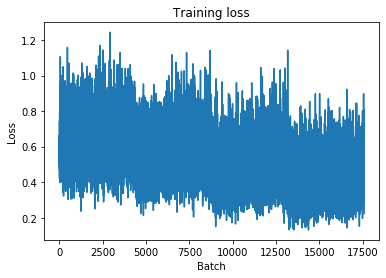

In [46]:
plt.plot(train_loss_set)
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

In [47]:
# Genrating predictions on the test data
# Create sentence and label lists
sentences = test_df.Phrase.values
sentences.shape

(66292,)

In [48]:
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
sentences

['[CLS] An intermittently pleasing but mostly routine effort . [SEP]',
 '[CLS] An intermittently pleasing but mostly routine effort [SEP]',
 '[CLS] An [SEP]',
 '[CLS] intermittently pleasing but mostly routine effort [SEP]',
 '[CLS] intermittently pleasing but mostly routine [SEP]',
 '[CLS] intermittently pleasing but [SEP]',
 '[CLS] intermittently pleasing [SEP]',
 '[CLS] intermittently [SEP]',
 '[CLS] pleasing [SEP]',
 '[CLS] but [SEP]',
 '[CLS] mostly routine [SEP]',
 '[CLS] mostly [SEP]',
 '[CLS] routine [SEP]',
 '[CLS] effort [SEP]',
 '[CLS] . [SEP]',
 "[CLS] Kidman is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves as yet another example of the sad decline of British comedies in the post-Full Monty world . [SEP]",
 '[CLS] Kidman [SEP]',
 "[CLS] is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves as yet ano

In [49]:
# Tokenize all the sentences
tokenized = [tokenizer.tokenize(sentence) for sentence in sentences]
print('\nTokenized 1st sentence: ', tokenized[0])


Tokenized 1st sentence:  ['[CLS]', 'an', 'intermittent', '##ly', 'pleasing', 'but', 'mostly', 'routine', 'effort', '.', '[SEP]']


In [50]:
# Converting the tokens to their index numbers in the BERT vocabulary using BERT tokenizer 
test_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized]
np.shape(test_input_ids)

(66292,)

In [52]:
# Pad the tokens to be all of same size 80 length vectors
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
test_input_ids.shape

(66292, 80)

In [53]:
# Create attention masks
test_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in test_input_ids:
    seq_mask = [float(i>0) for i in seq]
    test_attention_masks.append(seq_mask)

In [54]:
test_df.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [55]:
test_df['Sentiment'] = 0
test_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,An intermittently pleasing but mostly routine ...,0
1,156062,8545,An intermittently pleasing but mostly routine ...,0
2,156063,8545,An,0
3,156064,8545,intermittently pleasing but mostly routine effort,0
4,156065,8545,intermittently pleasing but mostly routine,0


In [56]:
test_labels = test_df.Sentiment.values

In [57]:
test_input_ids =torch.tensor(test_input_ids)
test_attention_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)

In [58]:
test_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [59]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
    # Forward pass, calculate logit predictions
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    #   true_labels.append(label_ids)

In [64]:
np.shape(predictions)

(2072,)

In [65]:
pred = np.concatenate(predictions)
pred.shape

(66292, 5)

In [67]:
labels = np.argmax(pred, axis =1)

In [69]:
submission = pd.DataFrame({'PhraseId': test_df['PhraseId'], 'Sentiment': labels})
submission.to_csv('submission.csv', index=False)
submission.head()

,PhraseId,Sentiment
0,156061,2
1,156062,3
2,156063,2
3,156064,3
4,156065,3


Kaggle score
<img src='result/sentiment_analysis.png' />